In [1]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib

# Carregando os dados

In [2]:
itemsets_or_not_path = pathlib.Path("./data/itemsets_and_not.csv")
itemsets_or_not_df = pd.read_csv(itemsets_or_not_path)
itemsets_or_not_df.head()

,station,Longitude,Latitude,in itemset
0,A042,-48.131111,-15.599722,0
1,A046,-48.137500,-15.935278,0
2,A047,-47.557500,-16.011111,0
3,A056,-47.625833,-16.399444,0
4,A029,-49.914722,-17.336944,0


# Pre-processando os dados

In [3]:
scaler = StandardScaler()
itemset_without_station = itemsets_or_not_df.drop('station', axis=1)
stations_on_itemset_df = itemset_without_station.query("`in itemset` == 1")
coords_itemsets = itemset_without_station.drop('in itemset', axis=1)
scaler.fit(coords_itemsets)

StandardScaler()

In [4]:
scaler.mean_

array([-48.36099058, -15.77400044])

In [5]:
transformed_stations_on_itemset_df = scaler.transform(
        stations_on_itemset_df.drop('in itemset', axis=1)
    )

# Testando o DBSCAN

Vou realizar um grid search sobre algumas configurações e avaliá-las com o [Silhouette](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) e [Bouldin](https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index).

In [6]:
grid_search_params = {"eps":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                      'min_samples':[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [7]:
def good_clusters(clusters_set:set):
    if -1 in clusters_set:
        clusters_set.remove(-1)
    
    return len(clusters_set) > 1

dbscan_results = dict()
for eps_v in grid_search_params['eps']:
    for min_samples_v in grid_search_params['min_samples']:
        clustering = DBSCAN(eps=eps_v, min_samples=min_samples_v, n_jobs=-1).fit(
            transformed_stations_on_itemset_df
        )
        labels = clustering.labels_
        if not good_clusters(set(labels)):
            continue
            
        silhouette = metrics.silhouette_score(
            transformed_stations_on_itemset_df, labels, metric='euclidean'
        )
        bouldin = metrics.davies_bouldin_score(
            transformed_stations_on_itemset_df, labels)
        
        dbscan_results[(eps_v, min_samples_v)] = {"silhouette": silhouette, 'bouldin': bouldin, 'groups':len(set(labels))}        

In [8]:
dbscan_results_df = pd.DataFrame.from_records(dbscan_results).T
dbscan_results_df

,silhouette,bouldin,groups
"(0.1, 3)",-0.175088,1.362992,23.0
"(0.1, 4)",-0.239971,1.250316,17.0
"(0.1, 5)",-0.296688,1.311108,11.0
"(0.1, 6)",-0.221330,1.061769,3.0
"(0.2, 3)",0.274294,1.567142,9.0
"(0.2, 4)",0.226329,2.355164,9.0
"(0.2, 5)",0.146681,1.645564,7.0
"(0.2, 6)",0.064409,1.562934,6.0
"(0.2, 7)",0.187971,1.074925,4.0
"(0.2, 8)",0.233725,1.013074,3.0


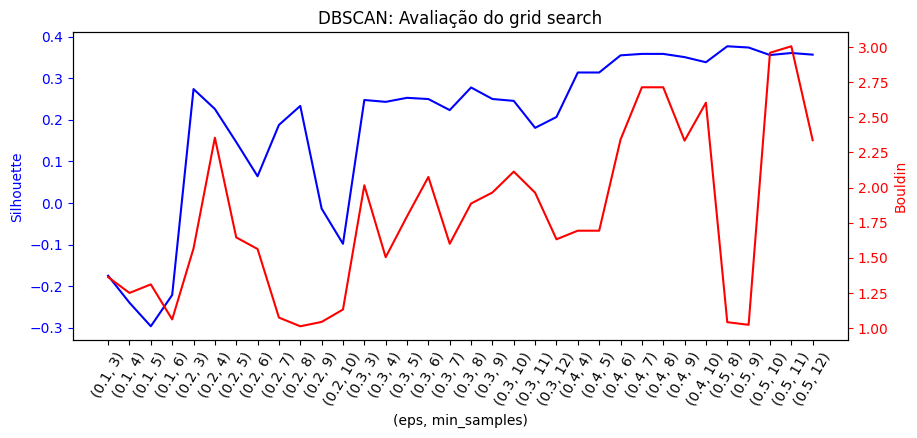

In [9]:
index_as_str_list = [str(el) for el in dbscan_results_df.index] 

fig, ax1 = plt.subplots(figsize=(10, 4))
sns.lineplot(data=dbscan_results_df, x=index_as_str_list, y='silhouette', ax=ax1, color='b')
plt.xticks(rotation=60)
ax1.set_ylabel('Silhouette', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
sns.lineplot(data=dbscan_results_df, x=index_as_str_list, y='bouldin', ax=ax2, color='r')
ax2.set_ylabel('Bouldin', color='r')
ax2.tick_params('y', colors='r')

ax1.set_xlabel("(eps, min_samples)")
plt.title("DBSCAN: Avaliação do grid search")
plt.savefig("./assets/dbscan_avaliacao.png", bbox_inches='tight')
plt.show()

In [10]:
dbscan_results_df[dbscan_results_df['silhouette'] == dbscan_results_df['silhouette'].max()]

,silhouette,bouldin,groups
"(0.5, 8)",0.377308,1.042286,3.0


In [11]:
dbscan_results_df[dbscan_results_df['bouldin'] == dbscan_results_df['bouldin'].min()]

,silhouette,bouldin,groups
"(0.2, 8)",0.233725,1.013074,3.0


A combinação com a maior silhouette é a eps=0.5 e min_samples=8. Já para menor bouldin de 1.01 é (0.2, 8).
Também existe uma boa combinação com(0.5, 9).
Vamos visualizar os grupos feitos por esses parâmetros.

In [12]:
def plot_groups(df, x, y, hue, title, save_path=None):
    climate_background_img = plt.imread('assets/mapa_trab2.png')
    BBox = (-72.78666666, -29.31666666, -33.74166666, 4.47749999)
    fig, ax = plt.subplots(figsize = (6,6))
    sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=ax, s=20, palette='dark')
    sns.move_legend(ax, 'lower right')
    ax.set_title(title)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
    ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
    plt.ylabel(y)
    plt.xlabel(x)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [13]:
def plot_dbscan(eps:list, min_samples:list, save=False):
    for curr_eps, curr_min_sample in zip(eps, min_samples):
        clustering = DBSCAN(eps=curr_eps, min_samples=curr_min_sample, n_jobs=-1).fit(
                    transformed_stations_on_itemset_df
                )
        grouped_itemsets = stations_on_itemset_df.drop('in itemset', axis=1).copy()
        grouped_itemsets['group'] = clustering.labels_
        title=f'DBSCAN: eps={curr_eps}, min_samples={curr_min_sample} (noisy=-1)'
        if save:
            save_path = f"./assets/dbscan_eps_{str(curr_eps).replace('.', ',')}_min_samples_{curr_min_sample}.png"
        else:
            save_path=None
        plot_groups(grouped_itemsets, 'Longitude', 'Latitude', 'group', title,
                   save_path=save_path)

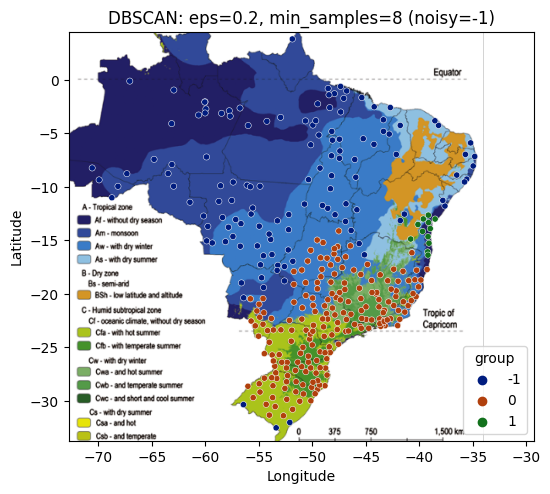

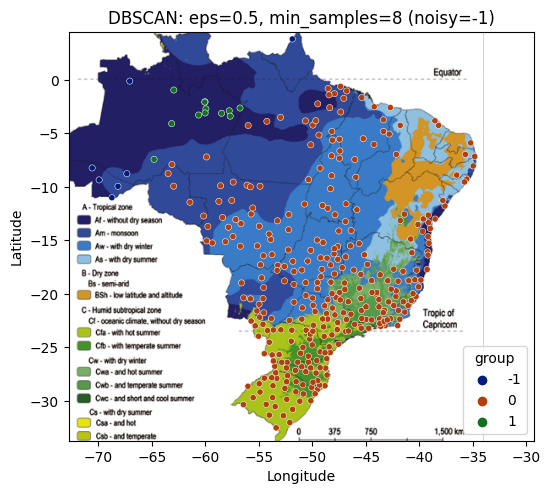

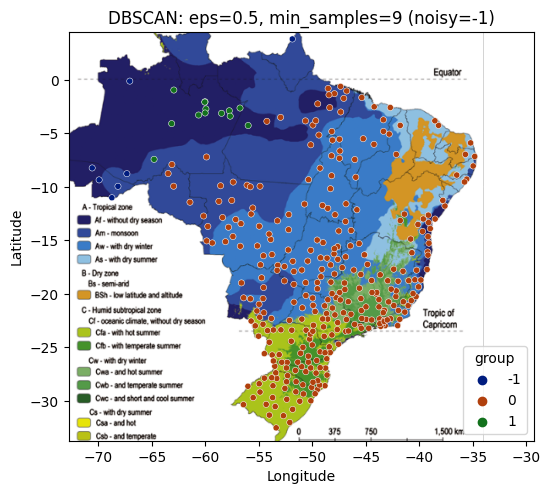

In [14]:
target_eps = [0.2, 0.5, 0.5]
target_min_samples = [8, 8, 9]

plot_dbscan(target_eps, target_min_samples, save=True)

# KMEANS

Também vou realizar um grid search utilizando o kmeans e avaliando com Silhouette e o Bouldin.

In [15]:
kmeans_grid_search_params = {"n_clusters":range(2, 12)}

In [16]:
results_kmeans = dict()
for n_c in kmeans_grid_search_params['n_clusters']:
    clustering = KMeans(n_clusters=n_c, random_state=42, init='k-means++', n_init="auto").fit(
        transformed_stations_on_itemset_df
    )

    labels = clustering.labels_
    if not good_clusters(set(labels)):
        continue
        
    silhouette = metrics.silhouette_score(
        transformed_stations_on_itemset_df, labels, metric='euclidean'
    )
    bouldin = metrics.davies_bouldin_score(
        transformed_stations_on_itemset_df, labels)
    
    results_kmeans[n_c] = {"silhouette": silhouette, 'bouldin': bouldin, 'groups':len(set(labels))}

In [17]:
results_kmeans_df = pd.DataFrame.from_records(results_kmeans).T
results_kmeans_df

,silhouette,bouldin,groups
2,0.429609,1.038437,2.0
3,0.434846,0.841938,3.0
4,0.423237,0.802294,4.0
5,0.400206,0.808246,5.0
6,0.428270,0.739735,6.0
7,0.422221,0.811428,7.0
8,0.417163,0.796330,8.0
9,0.419273,0.736418,9.0
10,0.427419,0.696268,10.0
11,0.419535,0.741618,11.0


In [18]:
results_kmeans_df[results_kmeans_df['silhouette'] == results_kmeans_df['silhouette'].max()]

,silhouette,bouldin,groups
3,0.434846,0.841938,3.0


In [19]:
results_kmeans_df[results_kmeans_df['bouldin'] == results_kmeans_df['bouldin'].min()]

,silhouette,bouldin,groups
10,0.427419,0.696268,10.0


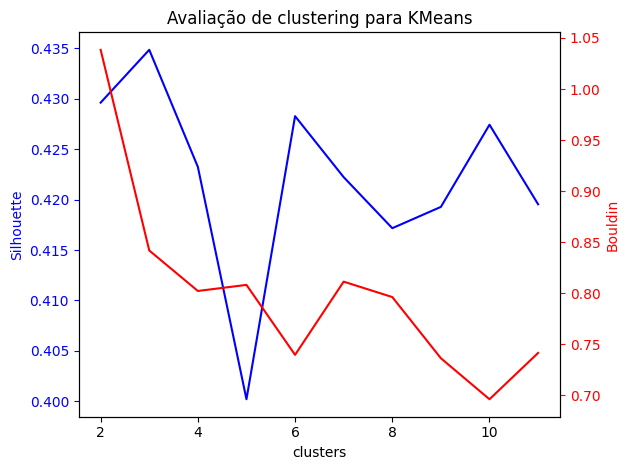

In [20]:
fig, ax1 = plt.subplots()
ten_kmeans = list(range(2, 12))
ax1.plot(ten_kmeans,results_kmeans_df['silhouette'] , 'b-')
ax1.set_xlabel('clusters')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Silhouette', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ten_kmeans, results_kmeans_df['bouldin'] , 'r-')
ax2.set_ylabel('Bouldin', color='r')
ax2.tick_params('y', colors='r')

plt.title("Avaliação de clustering para KMeans")
fig.tight_layout()
plt.savefig("./assets/kmeans_assesment_itemset.png")
plt.show()

Com k=3, temos o maior silhouette encontrado. Com k=10 temos o menor Bouldin. Com k=6, parece haver uma boa combinação de ambos.

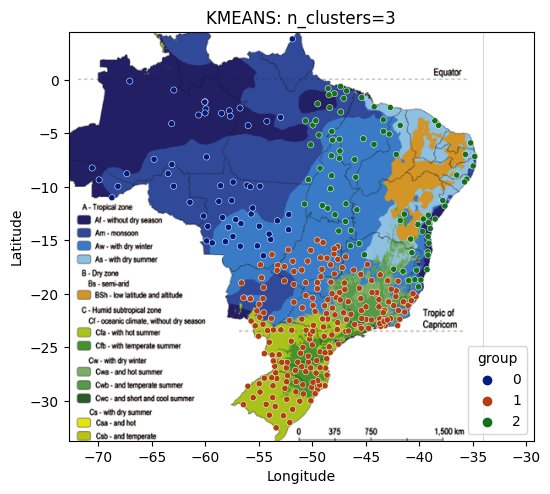

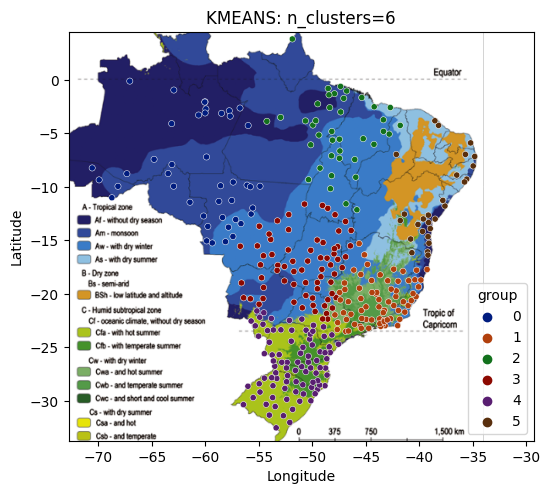

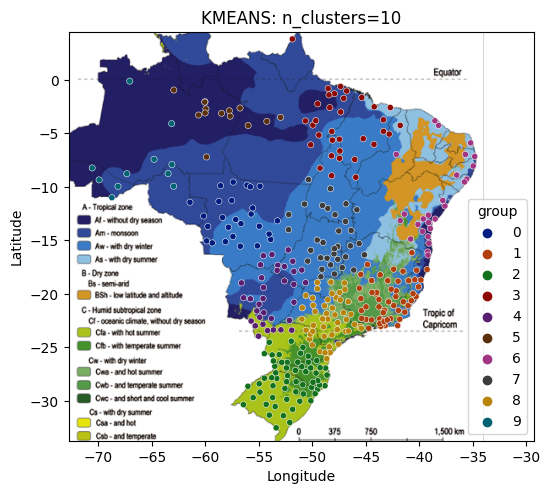

In [21]:
target_clusters = [3,6,10]
save_list = [True]*3
def plot_for_clusters(n_clusters, should_save=False):
    clustering = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++', n_init="auto").fit(
            transformed_stations_on_itemset_df
        )
    grouped_itemsets = stations_on_itemset_df.drop('in itemset', axis=1).copy()
    grouped_itemsets['group'] = clustering.labels_
    if should_save:
        save_path = f"./assets/kmeans_{n_clusters}.png"
    else:
        save_path = None
    plot_groups(grouped_itemsets, 'Longitude', 'Latitude', 'group', 
                f'KMEANS: n_clusters={n_clusters}', save_path)

for n_c,should_save in zip(target_clusters, save_list):
    plot_for_clusters(n_c, should_save)